In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score
from scipy import sparse
from scipy.special import entr


In [2]:
def get_likelihood(training_data):
    """
    Returns a dataframe with counts of each word in each class and total word counts in each class using below parameters.
     1.training_data = A dataframe representing the training data set. 
    
    """
    # Group the training data into size of number of classes x words by adding the all the words from same document into single row.
    label_word_counts = training_data.groupby(len(training_data.iloc[0])).sum()
    
    # Add a column named total_word_counts containing count of total words in each class.
    label_word_counts['total_word_counts'] = label_word_counts.sum(axis=1)
    
    # Return the dataframe with word counts and total word counts.
    return label_word_counts
           

In [3]:
def get_priors(training_data):
    """
    Returns the series of document counts of each class type in the training dataset using below parameter.
     1.training_data = A dataframe representing the training data set. 
    """
    # Adding a new column named label_counts to the given dataframe intializing it to 1 for all rows.
    training_data['label_counts'] = 1
    
    # Group the training dataset on the label column and get the label counts series into a variable
    document_label_counts = (training_data.groupby(len(training_data.iloc[0])-1).sum())['label_counts']
    
    # Remove the added column from the original dataset leaving it unmodified.
    del training_data['label_counts']
    
    # Return the label counts series.
    return document_label_counts       

In [4]:
def generate_output_labels(testing_data,likelihoods,priors,beta):
    """
    Generates the labels for documents from testing dataset using the below parameters.
     1.testing_data = A dataframe representing the testing data set documents to be classified.
     2.likelihoods = Counts of each word in each class and total words count in each class in the training dataset.
     3.priors = Series representing the number of documents of each class type among whole in the training dataset.
     
    """
    # Intializing alpha as 1+beta
    alpha = 1+beta
    
    # Calculate the prior for each class as number of documents of its type over total number of documents.
    total_documents = priors.sum()
    label_doc_ratios = np.array(np.log2(priors/total_documents))
    
    # Seperate the total word counts column from the likelihoods dataframe.
    label_word_counts =np.array(likelihoods['total_word_counts'])
    
    # Getting the length of vocabulary as the length of a testing row.
    length_of_vocabulary = len(testing_data.iloc[0])
    
    # Convert the testing data and likelihoods dataframes into sparse matrices for better performance. 
    # Also recalculating the likelihoods sparse matrix as per the formula.
    testing_data_csr = sparse.csr_matrix(testing_data)
    likelihoods_csr = sparse.csr_matrix(np.log2((np.transpose(likelihoods.iloc[:,:-1])+alpha-1)/(label_word_counts + ((alpha -1)* length_of_vocabulary))))
    
    # Performing a dot product between testing data and likelehoods. Add the priors and get the class with maximum probability for each document.
    probs = (np.dot(testing_data_csr, (likelihoods_csr))).toarray()
    
    for i in range(len(probs)):
        probs[i] = probs[i] + label_doc_ratios
        
    outputs = np.argmax(probs, axis=1)
    # Return the classified labels for each documents as an array.
    return np.squeeze(np.asarray(outputs))+1

In [5]:
def classify_testing_documents(training_data,testing_data):
    """
    Classifies the test documents and writes them to file using the below parameters.
     1.training_data = A dataframe representing the training data set. 
     2.testing_data = A dataframe representing the testing data set documents to be classified.
     
    """
    # Getting the length of vocabulary as the length of a training document without label and intializing beta.
    length_of_vocabulary = len(training_data.iloc[0])-1
    beta = 1/length_of_vocabulary
    
    # Getting the likehoods and priors using the training dataset.
    likelihoods = get_likelihood(training_data)
    priors = get_priors(training_data)
    
    # Generate the output labels for the documents in the testing dataset using likelihoods and priors.
    output_labels = generate_output_labels(testing_data,likelihoods,priors,beta)
    
    # Write the labels to a results_nb.csv file in the required format.
    df = pd.DataFrame(columns=['id','class'])
    for i in range(len(output_labels)):
        df.at[i,'id']=12001+i                       
        df.at[i,'class']= output_labels[i]
    df.to_csv('results_nb.csv',index=False)


In [6]:
def plot_confusion_matrix(y_true,y_pred,label_names):
    """
    Draws a confusion matrix for the given y_pred and y_true values.
     1. y_true = The actual classifications of the documents in the test dataset.
     2. y_pred = The predicted classifications of the documents from the test dataset.
     3. label_names = The actual names of the classes.    
    """
    
    # Calculate the confusion matrix using the expected and predicted values.
    confusion_mat = confusion_matrix(np.array(y_true),y_pred,label_names)
    
    #  Show the confusion matrix values.
    fig = plt.figure(figsize=(15,15))
    plt.imshow(confusion_mat, cmap=plt.cm.Blues, interpolation='nearest')
    
    # Set the x, y and title labels for the plot.
    plt.xlabel("Expected Outputes", fontsize=14)
    plt.ylabel("Actual Outputs", fontsize=14)
    plt.title("Confusion Matrix",fontsize=16)
    
    # Arrange the label names on the x and y axis.
    plt.xticks(np.arange(len(label_names)), label_names, rotation='75')
    plt.yticks(np.arange(len(label_names)), label_names)
    plt.tick_params(axis='both', labelsize='12')
    plt.tight_layout()
    for (y, x), label in np.ndenumerate(confusion_mat):
        if label != 0:
            plt.text(x,y,label,ha='center',va='center', size='14')
    # Show the plot
    plt.show()

In [7]:
def plot_accuracies(training_data,beta_list,label_names):
    """
    Classifies the test documents and writes them to file using the below parameters.
     1.training_data = A dataframe representing the training data set. 
     2.beta_list = A list of beta values we want to compare the accuracy for.
     3.label_names = Label names of the classes.
     
    """
    # Split the training data in the ration 7:3 as the train and validation sets.
    # Performing stratified split to make sure we preserve same percentage of samples from each class.
    train_labels = np.array(training_data[61189])

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in stratified_split.split(np.array(training_data), train_labels):
        train_set, validation_set = training_data.iloc[train_index],training_data.iloc[test_index]

    # Getting the likelihoods and priors for the train dataset.
    likelihoods = get_likelihood(train_set)
    priors = get_priors(train_set)

    # Creating an empty list to add the accuracies for each beta value.
    validation_accuracies = list()

    # Getting the true outputs of the documents from the validation dataset.
    true_outputs= np.array(validation_set.iloc[:,-1])

    for k in range(len(beta_list)):

        # Classifying the documents from validation dataset using likelihoods and priors for current beta value.
        actual_outputs = generate_output_labels(validation_set.iloc[:,:-1],likelihoods,priors,beta_list[k])

        # Getting the corresponding label names for the classificaitions.
        actual_outputs= [label_names[actual_outputs[i]-1] for i in range(len(actual_outputs))]
        expected_outputs= [label_names[true_outputs[i]-1] for i in range(len(true_outputs))]        

        # Calculationg and adding accuracy to the list.
        validation_accuracies=np.append(validation_accuracies,(accuracy_score(expected_outputs,actual_outputs))*100) 

        # Printing the Current Beta value, Accuracy and Confusion Matrix 
        print('Beta: '+str(beta_list[k]))
        print('\n Accuracy: '+ str(validation_accuracies[k]))
        print('\n Confusion Matrix: \n')
        plot_confusion_matrix(np.array(expected_outputs),actual_outputs,label_names)
        print('\n')

    # Plotting the Accuracies for the beta values using the Semilogx function.
    plt.semilogx(beta_list, validation_accuracies, linewidth=2.0)
    plt.xlabel('Beta')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for each Beta  value ')
    plt.show()   

In [42]:
def get_top_100_words(training_data):
    """
    Returns the top 100 ranked words from the vocabulary
    """
    # get the length of vocabulary and calculate beta, alpha
    length_of_vocabulary = len(training_data.iloc[0])-1
    beta = 1/length_of_vocabulary
    alpha = 1 + beta

    # get the likelyhood counts
    likelyhoods = get_likelihood(training_data)

    # get the vocabulary
    vocalbulary_list = np.loadtxt("vocabulary.txt",dtype='str', usecols=0)

    # Get the label word counts
    label_word_counts = np.array(likelyhoods['total_word_counts'])

    # Get the map probabilities
    map_probs = np.transpose(((np.transpose(likelyhoods.iloc[:,:-1]))+alpha-1)/(label_word_counts + ((alpha -1)* length_of_vocabulary)))

    # Calculate entropies for the map probabilities
    entropies = entr(map_probs)

    # Sum the entropies
    entropies = np.sum(entropies, axis =0)

    # Sort them in ascending order and take the first 100 values
    top_score_indexes = entropies.argsort()[:100]

    # Print the top 100 values
    print(vocalbulary_list[top_score_indexes])

In [ ]:
# Load the training and testing dataframes from CSV files
training_data = (pd.read_csv('training.csv',header=None)).drop(0,axis=1)
testing_data = (pd.read_csv('testing.csv',header=None)).drop(0,axis=1)

In [ ]:
#Intializing the beta list and loading the label names from the given text file.
beta_list = [.00001, .00005, .0001, .0005, .001, .005, .01, .05, .1, .5, 1]
label_names = np.loadtxt("newsgrouplabels.txt",dtype='str', usecols=1)

In [9]:
# Classifying the testing dataset documents and writes them to file named results_nb.csv
classify_testing_documents(training_data,testing_data)

Beta: 1e-05

 Accuracy: 86.5

 Confusion Matrix: 



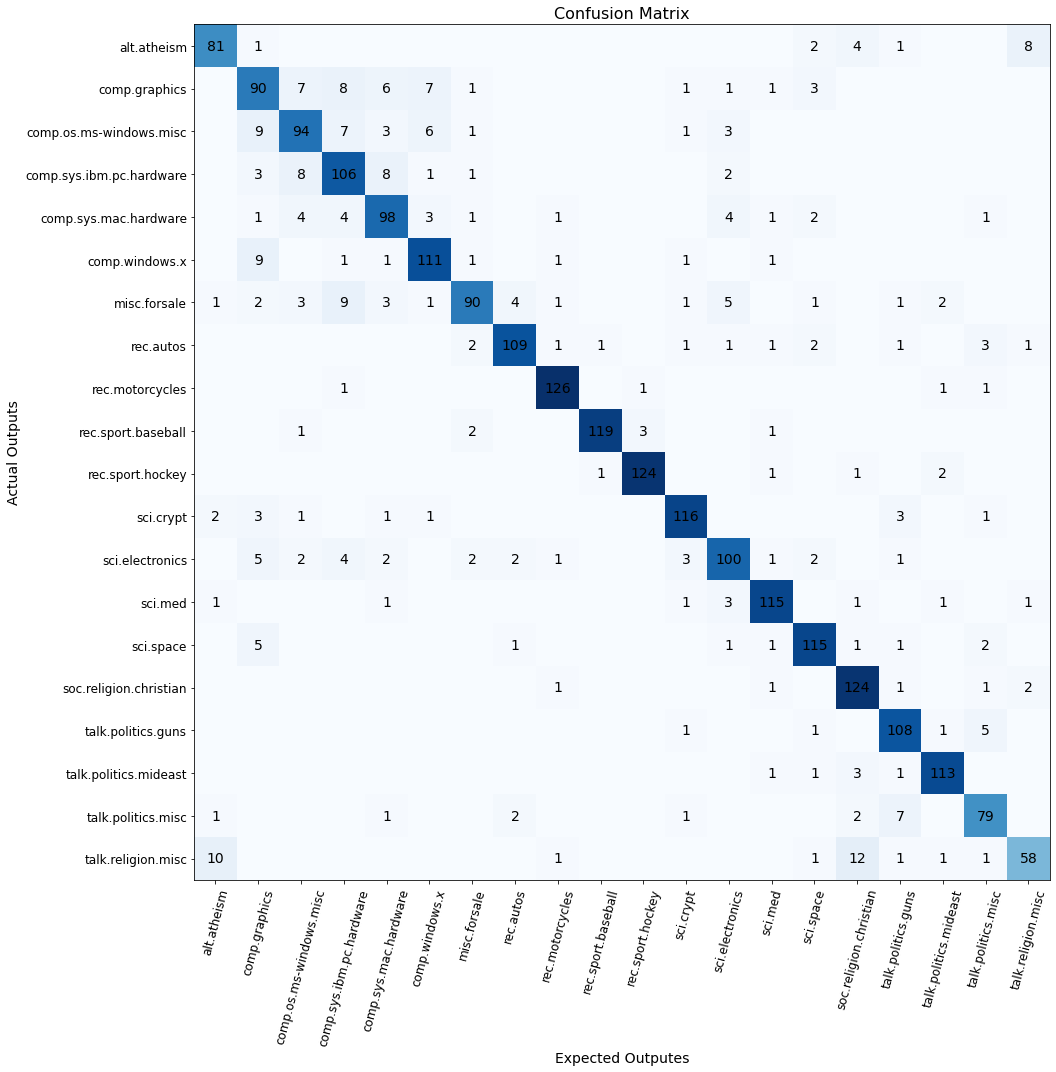



Beta: 5e-05

 Accuracy: 86.83333333333333

 Confusion Matrix: 



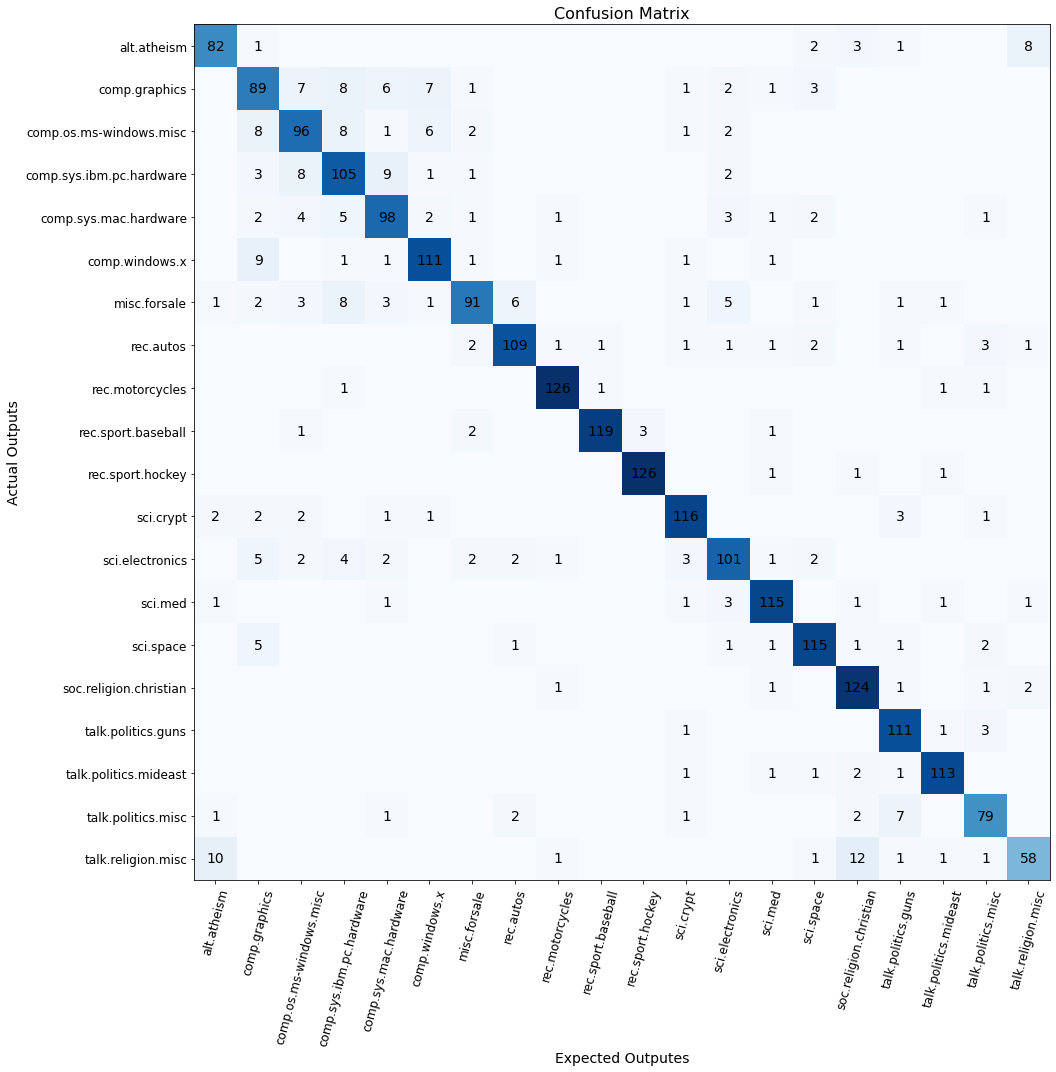



Beta: 0.0001

 Accuracy: 86.70833333333333

 Confusion Matrix: 



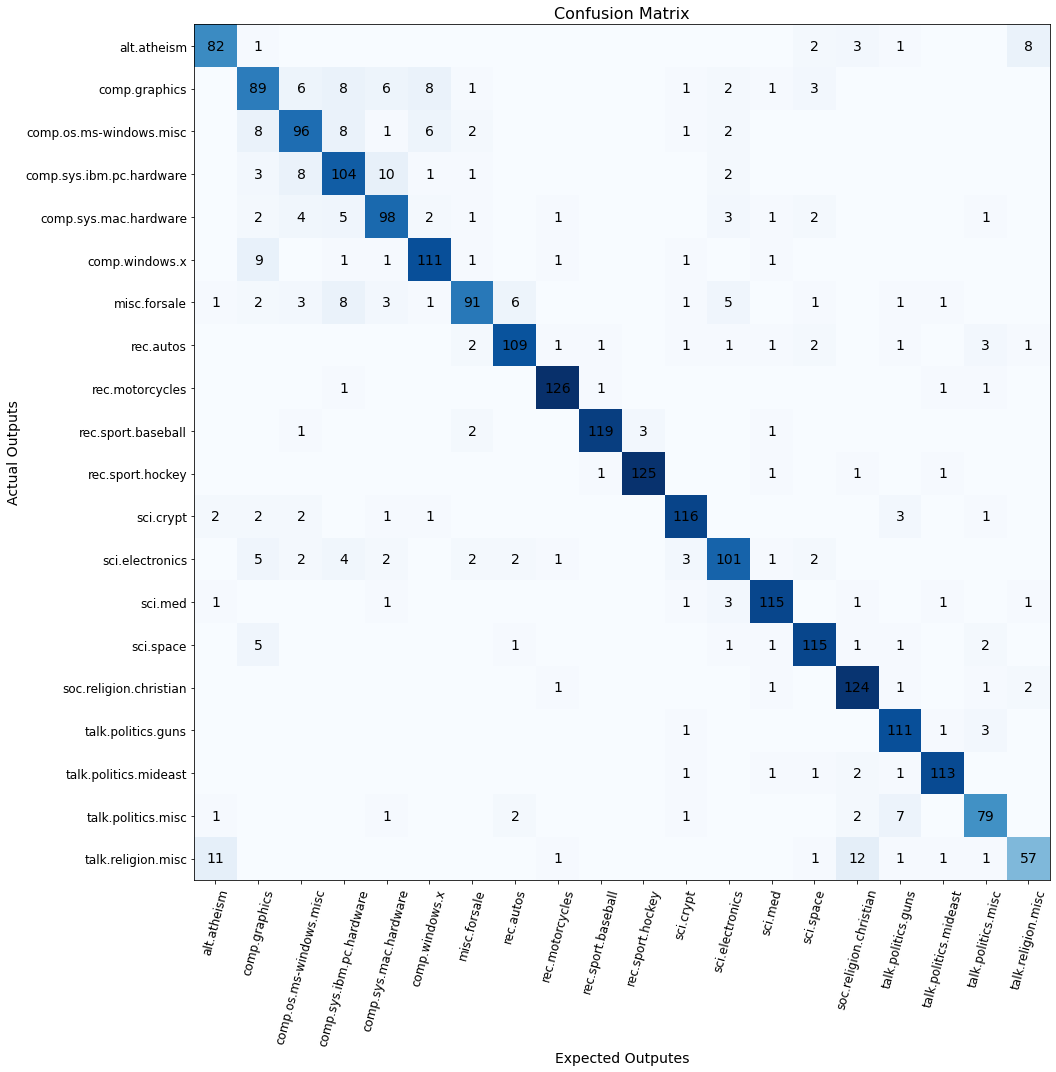



Beta: 0.0005

 Accuracy: 87.41666666666667

 Confusion Matrix: 



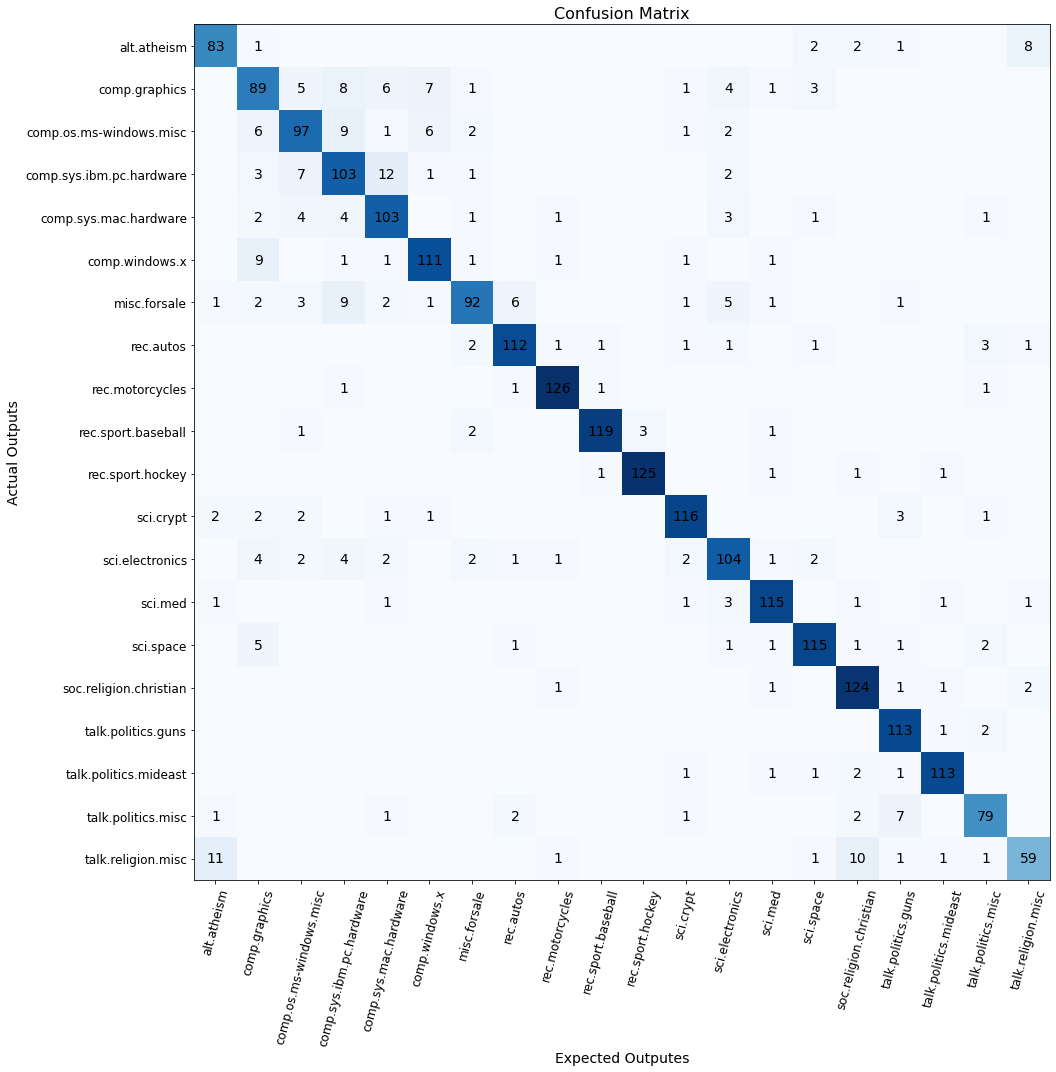



Beta: 0.001

 Accuracy: 87.45833333333334

 Confusion Matrix: 



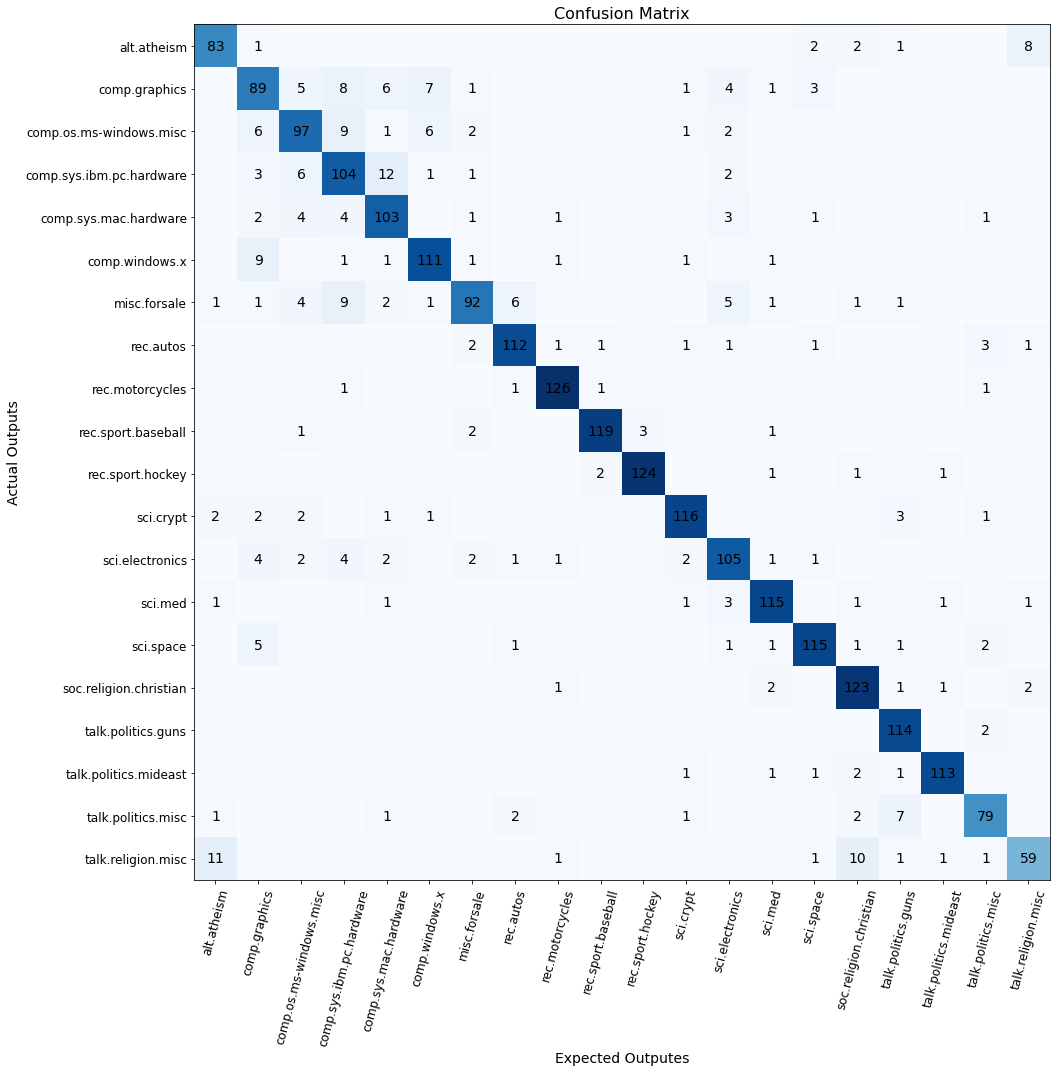



Beta: 0.005

 Accuracy: 87.66666666666667

 Confusion Matrix: 



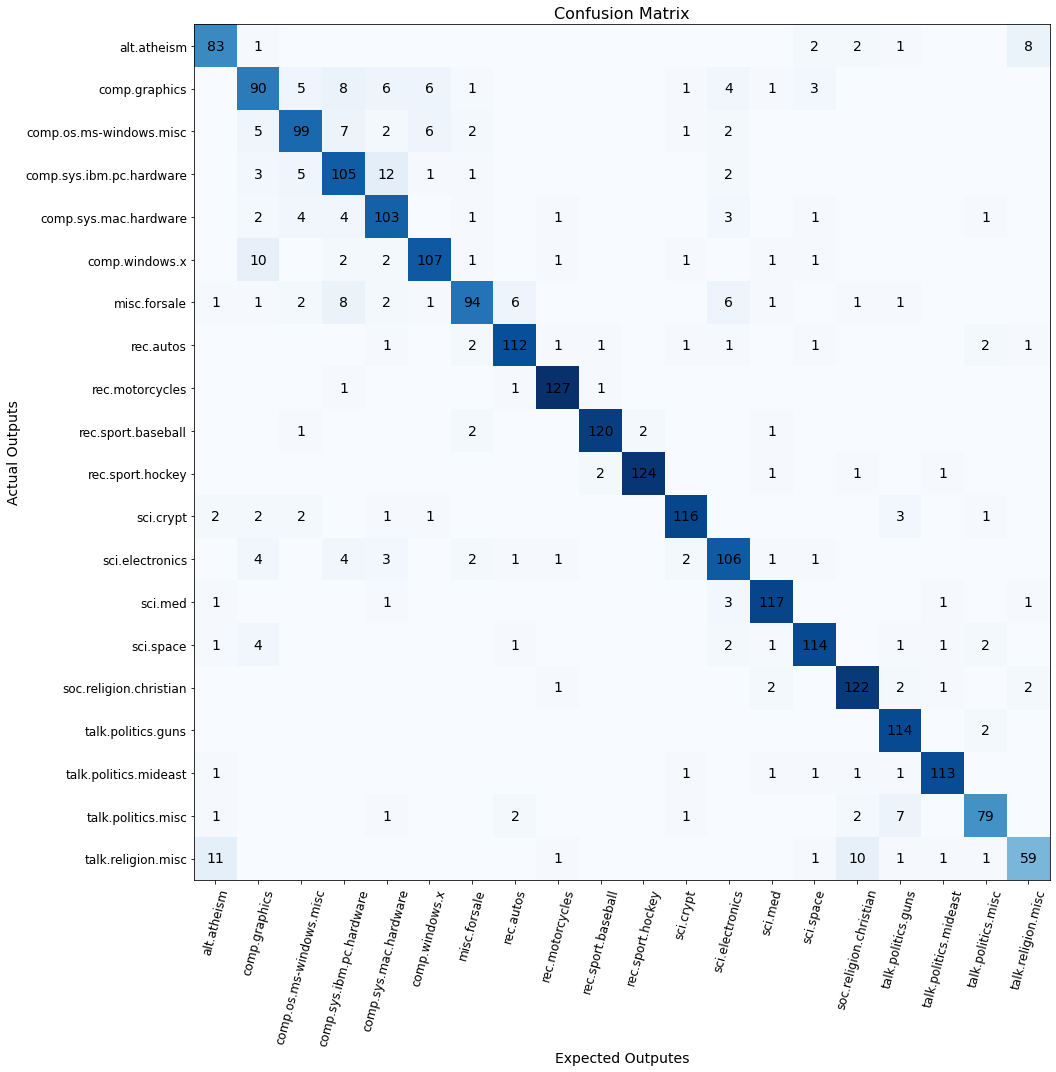



Beta: 0.01

 Accuracy: 87.75

 Confusion Matrix: 



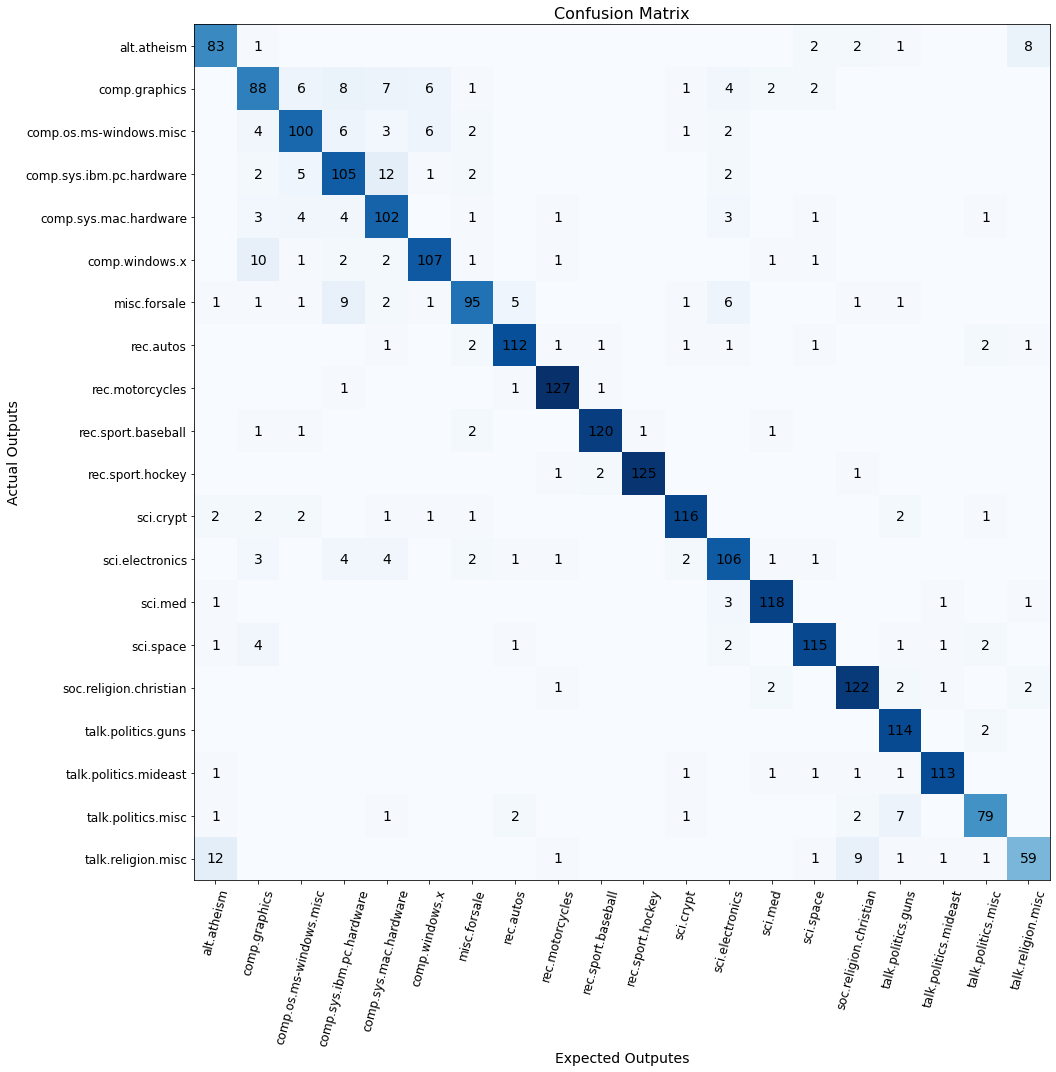



Beta: 0.05

 Accuracy: 87.66666666666667

 Confusion Matrix: 



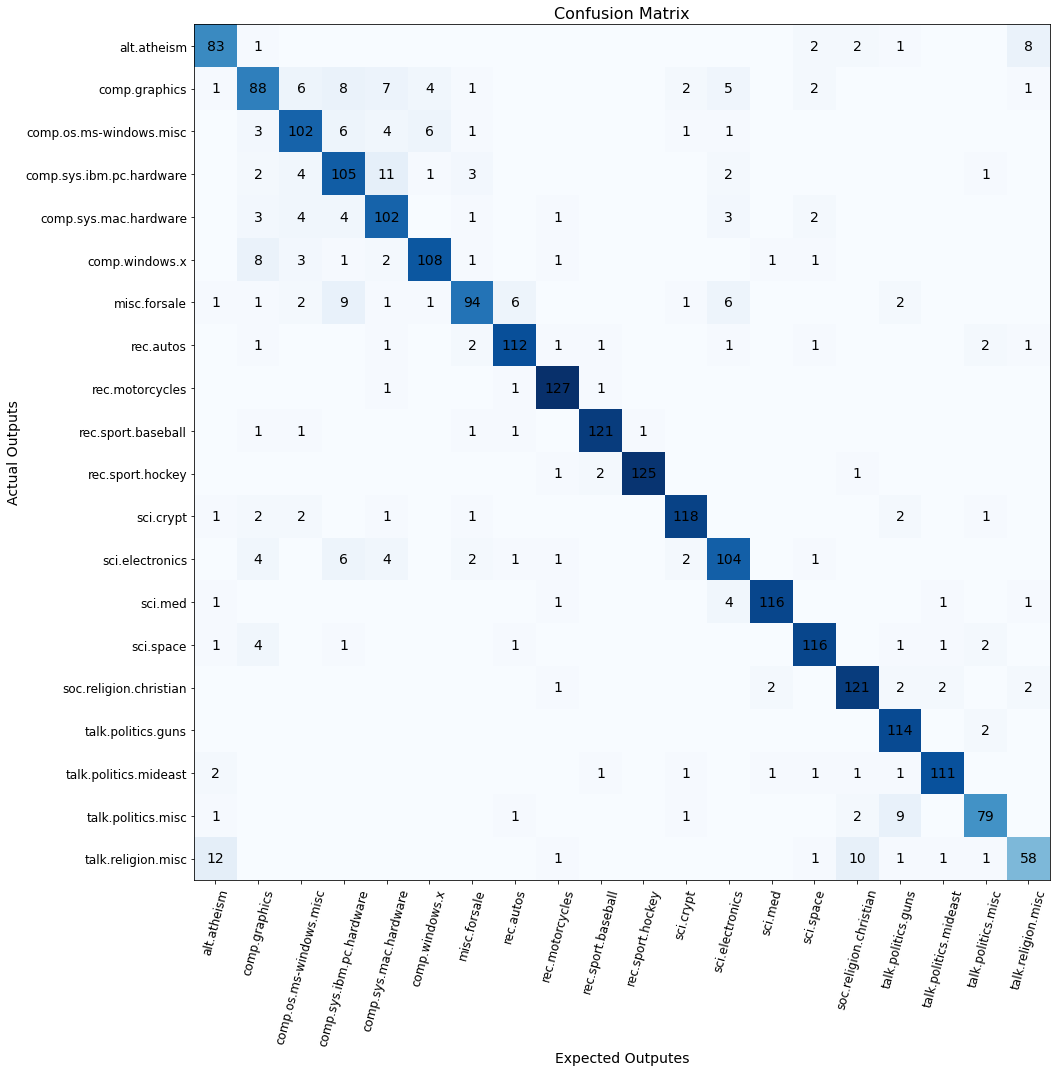



Beta: 0.1

 Accuracy: 87.75

 Confusion Matrix: 



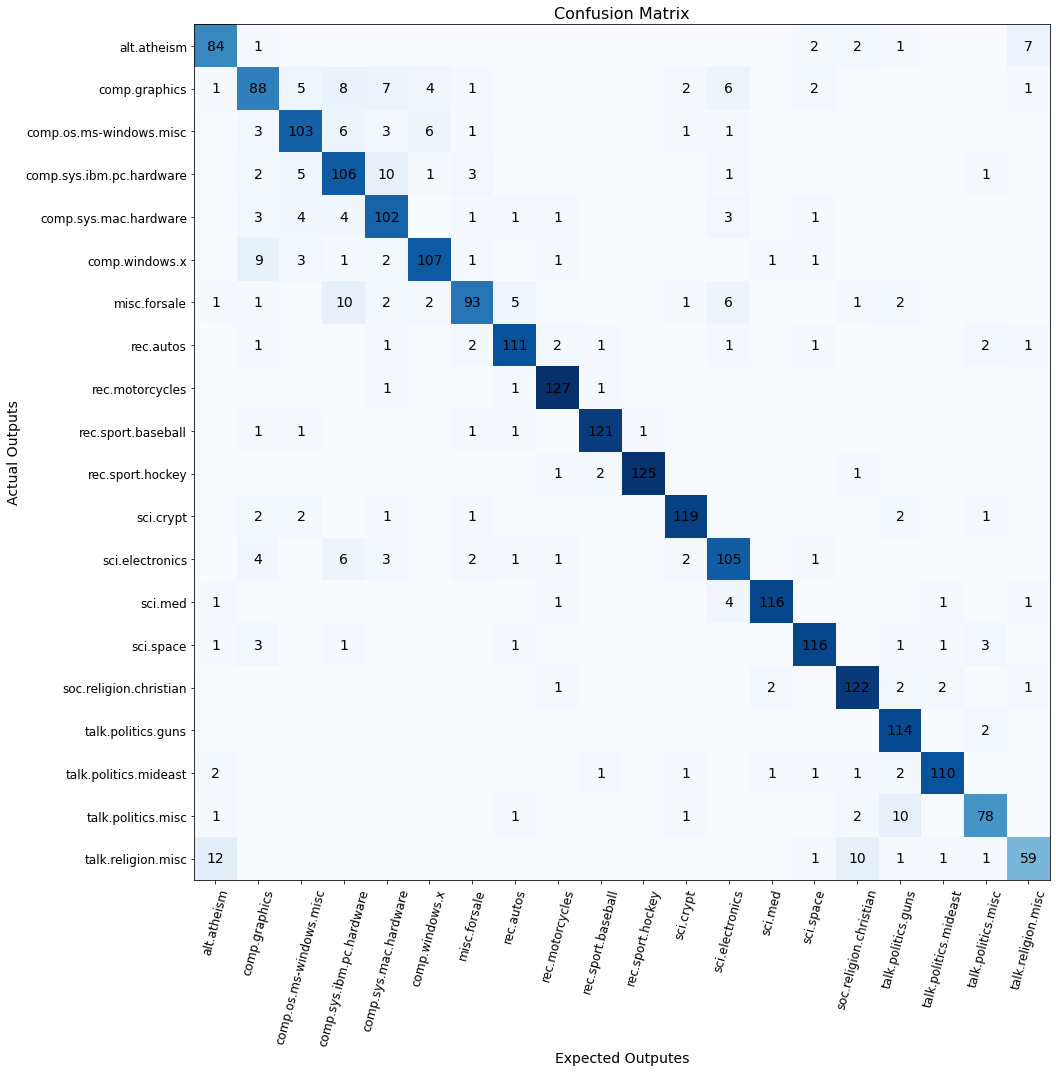



Beta: 0.5

 Accuracy: 85.875

 Confusion Matrix: 



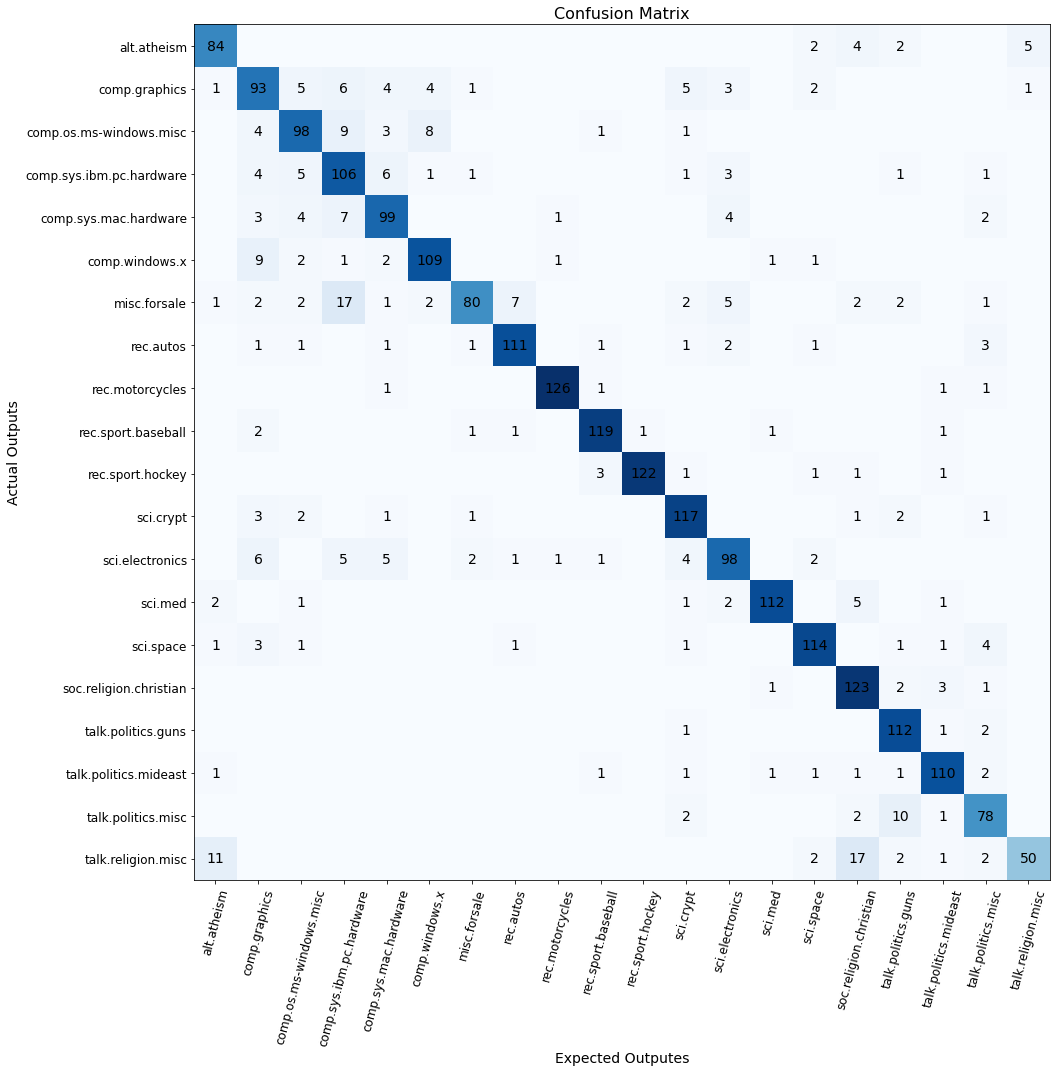



Beta: 1

 Accuracy: 83.58333333333333

 Confusion Matrix: 



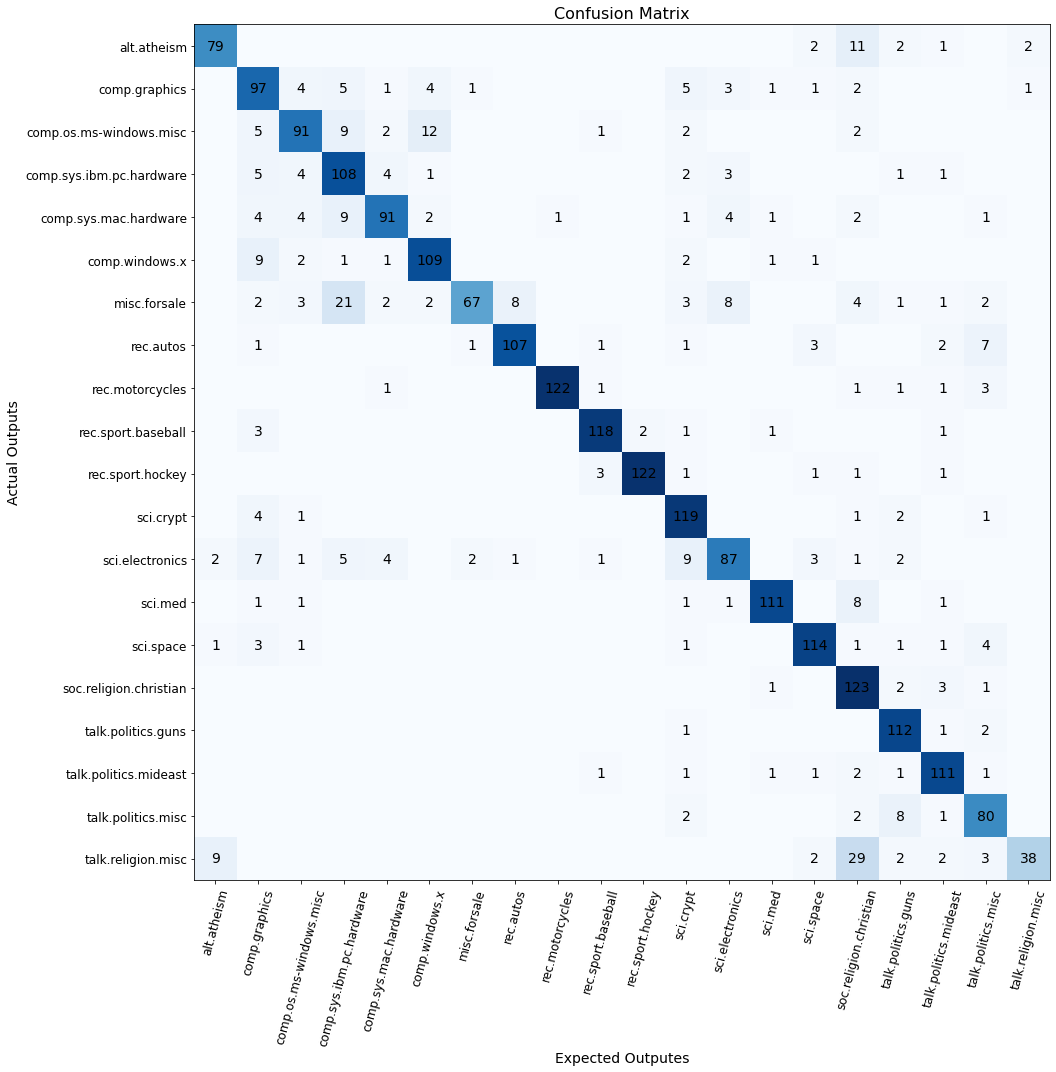

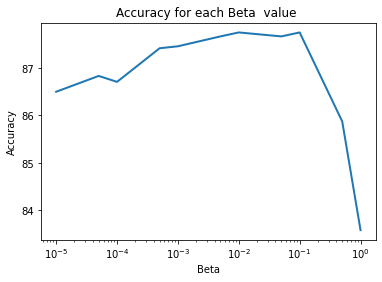

In [12]:
# Plotting the accuracies for the different beta values in list using training dataset.
pd.options.mode.chained_assignment = None 
plot_accuracies(training_data,beta_list,label_names)

In [ ]:
get_top_100_words(training_data)